In [1]:
import pandas as pd
import json
from environs import Env
from graph_functions import (query_to_df, 
                            start_graph_session, start_graph_session_crashdown,
                            is_it_cancer, is_it_breast_cancer)
from IPython.display import Image


env = Env()
#session = start_graph_session(env) 
session = start_graph_session_crashdown(env) 

14196


In [2]:
genes_gwas_exp = pd.read_csv("query_results/bc_gwas_expressed_in_breastTissue.tsv", sep = '\t') # from notebook 2
genes_gwas_exp['about'].value_counts()


cancer_target    13
drug_target       6
Name: about, dtype: int64

In [3]:
# genes that are not known targets for cancer drugs
gene_list = list(set(genes_gwas_exp[genes_gwas_exp['about']!='cancer_target']['gene.name']))
len(gene_list)

93

### Plan: gene->protein; map to pathway - find all other proteins in the in the pathways; map them to genes; then those genes to drugs and diseases

In [4]:
#  pathways where proteins of genes [without cancer-related drug targets] are found
query = """
    MATCH (gene1:Gene)-[gene_to_protein:GENE_TO_PROTEIN]->(protein:Protein)-[protein_in_pathway:PROTEIN_IN_PATHWAY]->(pathway:Pathway) 
    WHERE gene1.name in {}
    RETURN gene1.name, protein.uniprot_id, 
           collect (pathway.name) as Pathways, count (pathway.name) as N_pathways 
    ORDER BY N_pathways desc
    """.format(gene_list)

df1 = query_to_df(session, query)
df1
#len(set(df1['gene1.name'])) # 51 protrin coding genes


    MATCH (gene1:Gene)-[gene_to_protein:GENE_TO_PROTEIN]->(protein:Protein)-[protein_in_pathway:PROTEIN_IN_PATHWAY]->(pathway:Pathway) 
    WHERE gene1.name in ['SSBP4', 'ZMIZ1', 'CDYL2', 'TRIM46', 'RANBP9', 'MKL1', 'ARRDC3', 'HSCB', 'ITPR1', 'TLR1', 'ANKLE1', 'CASP8', 'KRTCAP2', 'TTC28', 'ADCY3', 'HSPA4', 'FAM46A', 'CREB5', 'VGLL3', 'ELL', 'MLLT10', 'CCDC88C', 'CDCA7L', 'KCNN4', 'PHLDA3', 'FTO', 'CMSS1', 'SETBP1', 'RP11-134G8.8', 'RIN3', 'ADSSL1', 'NRIP1', 'OTUD7B', 'MDM4', 'OR2A1-AS1', 'RNF115', 'TET2', 'RCCD1', 'SLC25A22', 'DNAJC1', 'SF3B4', 'FILIP1L', 'ARHGEF5', 'GAREM', 'MTMR11', 'MCM8', 'ULK3', 'GIPR', 'L3MBTL3', 'LINC-PINT', 'ABO', 'SV2A', 'EBF1', 'AMFR', 'NREP', 'ZFPM2', 'FAM175A', 'TACC2', 'TGFBR2', 'ZBTB38', 'ATXN7', 'ATAD5', 'ZNF184', 'STXBP4', 'N4BP2L1', 'GATAD2A', 'CUX1', 'CDKN2B', 'LGR6', 'CBX8', 'USHBP1', 'TCF7L2', 'SUB1', 'LSP1', 'ATG10', 'KANSL1', 'VPS33B', 'NEK10', 'BABAM1', 'RAD51B', 'ADCY9', 'FOXP1', 'MYEOV', 'PLA2G6', 'MAGI3', 'PEX14', 'PIDD', 'SCAMP2', 'PRC1', 'L

,gene1.name,protein.uniprot_id,Pathways,N_pathways
0,ITPR1,Q14643,"[Signaling by the B Cell Receptor (BCR), Antig...",50
1,CASP8,Q14790,"[Defective RIPK1-mediated regulated necrosis, ...",42
2,ADCY3,O60266,"[Activation of GABAB receptors, GABA B recepto...",40
3,ADCY9,O60503,"[Activation of GABAB receptors, GABA B recepto...",40
4,ELL,P55199,"[RNA Polymerase II Transcription Elongation, G...",26
5,MDM4,O15151,"[Cellular responses to external stimuli, Gene ...",24
6,GATAD2A,Q86YP4,"[SARS-CoV Infections, Potential therapeutics f...",24
7,TCF7L2,Q9NQB0,"[RUNX3 regulates WNT signaling, Transcriptiona...",24
8,CBX8,Q9HC52,"[Intracellular signaling by second messengers,...",23
9,MCM8,Q9UJA3,"[Cell Cycle Checkpoints, G2/M Checkpoints, DNA...",21


In [5]:
# map gene-protein to to pathway - find all other proteins in the pathways; map them to genes;

query = """
    MATCH (gene1:Gene)-[gene_to_protein:GENE_TO_PROTEIN]->(protein1:Protein)-[protein_in_pathway:PROTEIN_IN_PATHWAY]->(pathway:Pathway)<-[PROTEIN_IN_PATHWAY]-(protein2:Protein)-[GENE_TO_PROTEIN]-(gene2:Gene)
    //WHERE gene1.name in ['ATG10', 'TGFBR2']
    WHERE gene1.name in {}
    RETURN gene1.name, protein1.uniprot_id, pathway.name, pathway.id,
    collect(gene2.name) as `all_genes_from_proteins`, 
    count(gene2.name) as `N_genes_from_proteins`
    ORDER BY `N_genes_from_proteins` desc 
    """.format(list(df1['gene1.name']))
df_genes_to_genes = query_to_df(session, query)
df_genes_to_genes

#len(set(df_genes_to_genes['pathway.name'])) # 365 unique pathways


    MATCH (gene1:Gene)-[gene_to_protein:GENE_TO_PROTEIN]->(protein1:Protein)-[protein_in_pathway:PROTEIN_IN_PATHWAY]->(pathway:Pathway)<-[PROTEIN_IN_PATHWAY]-(protein2:Protein)-[GENE_TO_PROTEIN]-(gene2:Gene)
    //WHERE gene1.name in ['ATG10', 'TGFBR2']
    WHERE gene1.name in ['ITPR1', 'CASP8', 'ADCY3', 'ADCY9', 'ELL', 'MDM4', 'GATAD2A', 'TCF7L2', 'CBX8', 'MCM8', 'TLR1', 'TGFBR2', 'CDKN2B', 'PLA2G6', 'FAM175A', 'BABAM1', 'RANBP9', 'NRIP1', 'GIPR', 'RAD51B', 'OTUD7B', 'ARHGEF5', 'MKL1', 'SV2A', 'ATXN7', 'PEX14', 'VPS33B', 'PIDD', 'AMFR', 'CUX1', 'SF3B4', 'PRC1', 'HSCB', 'SLC25A22', 'HSPA4', 'GRHL1', 'CCDC88C', 'TRIM46', 'CUX1', 'ADSSL1', 'RIN3', 'RNF115', 'LGR6', 'KANSL1', 'ZNF184', 'KCNN4', 'ULK3', 'FTO', 'TET2', 'ATG10', 'EBF1', 'ZFPM2']
    RETURN gene1.name, protein1.uniprot_id, pathway.name, pathway.id,
    collect(gene2.name) as `all_genes_from_proteins`, 
    count(gene2.name) as `N_genes_from_proteins`
    ORDER BY `N_genes_from_proteins` desc 
    


,gene1.name,protein1.uniprot_id,pathway.name,pathway.id,all_genes_from_proteins,N_genes_from_proteins
0,NRIP1,P48552,Signal Transduction,R-HSA-162582,"[HIST1H2BN, PRMT1, MYD88, SMO, ARHGDIG, EPAS1,...",2750
1,PRC1,O43663,Signal Transduction,R-HSA-162582,"[HIST1H2BN, PRMT1, MYD88, SMO, ARHGDIG, EPAS1,...",2750
2,OTUD7B,Q6GQQ9,Signal Transduction,R-HSA-162582,"[HIST1H2BN, PRMT1, MYD88, SMO, ARHGDIG, EPAS1,...",2750
3,RANBP9,Q96S59,Signal Transduction,R-HSA-162582,"[HIST1H2BN, PRMT1, MYD88, SMO, ARHGDIG, EPAS1,...",2750
4,ITPR1,Q14643,Signal Transduction,R-HSA-162582,"[HIST1H2BN, PRMT1, MYD88, SMO, ARHGDIG, EPAS1,...",2750
...,...,...,...,...,...,...
622,TGFBR2,P37173,Loss of Function of TGFBR2 in Cancer,R-HSA-3642278,"[TGFBR1, TGFB1]",2
623,TCF7L2,Q9NQB0,TCF7L2 mutants don't bind CTBP,R-HSA-5339700,"[CTBP1, CTBP2]",2
624,TGFBR2,P37173,TGFBR2 Kinase Domain Mutants in Cancer,R-HSA-3645790,"[TGFBR1, TGFB1]",2
625,SV2A,Q7L0J3,Toxicity of botulinum toxin type E (BoNT/E),R-HSA-5250992,"[SV2B, SNAP25]",2


In [6]:
# collect all genes involved in pathways
gene2_list = list(set(df_genes_to_genes['all_genes_from_proteins'].explode()))
len(gene2_list)

10220

In [7]:
# map genes to drugs and diseases
query="""
match (gene:Gene)-[]-(drug:Drug)-[]-(d:Disease)
where gene.name in {}
return gene.name , drug.label, d.label
""".format(gene2_list)
df2= query_to_df(session, query, False)
df2
#len(set(df2['gene.name'])) # 1069 / 10220 genes are drug targets

,gene.name,drug.label,d.label
0,AURKB,DANUSERTIB,plasma cell myeloma
1,AURKB,DANUSERTIB,leukemia (disease)
2,AURKA,DANUSERTIB,plasma cell myeloma
3,AURKA,DANUSERTIB,leukemia (disease)
4,FGR,ILORASERTIB,cancer
...,...,...,...
10665,PTGS1,ANTIPYRINE,Fever
10666,PTGS1,ALCLOFENAC,rheumatologic disorder
10667,TLR7,IMIQUIMOD,actinic keratosis (disease)
10668,TGFBR1,GALUNISERTIB,hepatocellular carcinoma


In [8]:
# check if drug/disease is cancer related
df2 = is_it_cancer(df2, 'd.label')
df2

,gene.name,drug.label,d.label,is_it_cancer
0,AURKB,DANUSERTIB,plasma cell myeloma,yes
1,AURKB,DANUSERTIB,leukemia (disease),yes
2,AURKA,DANUSERTIB,plasma cell myeloma,yes
3,AURKA,DANUSERTIB,leukemia (disease),yes
4,FGR,ILORASERTIB,cancer,yes
...,...,...,...,...
10665,PTGS1,ANTIPYRINE,Fever,no
10666,PTGS1,ALCLOFENAC,rheumatologic disorder,no
10667,TLR7,IMIQUIMOD,actinic keratosis (disease),no
10668,TGFBR1,GALUNISERTIB,hepatocellular carcinoma,yes


In [9]:
# review it_it_cancer by counts 
#pd.Series(df2.groupby(["gene.name", "is_it_cancer"]).size())

In [10]:
# list all non-cancer diseases for spot checking
set(df2[df2['is_it_cancer']=='no']['d.label'])

{'ACTH-dependent Cushing syndrome',
 'AIDS',
 'Abnormality of blood and blood-forming tissues',
 'Abnormality of connective tissue',
 'Abnormality of the thyroid gland',
 'Agitation',
 'Alzheimer disease',
 'Apnea',
 'Arthralgia',
 'Barrett esophagus',
 'Bilateral tonic-clonic seizure',
 'Bronchiectasis',
 'COVID-19',
 'Cachexia',
 'Castleman disease',
 'Chronic pain',
 'Clostridium difficile colitis',
 'Cognitive impairment',
 'Constipation',
 'Cough',
 'Crohn disease',
 "Crohn's colitis",
 'Dementia',
 'Diarrhea',
 'Eczema',
 'Fever',
 'HIV infectious disease',
 'HIV wasting syndrome',
 'Headache',
 'Helicobacter pylori infectious disease',
 'Hepatic steatosis',
 'Hepatitis',
 'Hypercalcemia',
 'Hypercholesterolemia',
 'Hyperhidrosis',
 'Hypocalcemia',
 'Hypoglycemia',
 'Hypogonadotropic hypogonadism',
 'IgA glomerulonephritis',
 'Inguinal hernia',
 'Ischemic stroke',
 'Klinefelter syndrome',
 'Langerhans cell histiocytosis',
 'Lewy body dementia',
 'Meniere disease',
 'Menorrhagia',

In [11]:
# subset to genes that are cancer drug tagets
df3= df2[df2['is_it_cancer']=='yes'][['gene.name', 'drug.label', 'd.label']]
df3
#len(set(df3['gene.name'])) # 590 / 1069 are cancer drug targets

#df3.to_csv("query_results/tmp2.tsv", sep="\t", index=False)

,gene.name,drug.label,d.label
0,AURKB,DANUSERTIB,plasma cell myeloma
1,AURKB,DANUSERTIB,leukemia (disease)
2,AURKA,DANUSERTIB,plasma cell myeloma
3,AURKA,DANUSERTIB,leukemia (disease)
4,FGR,ILORASERTIB,cancer
...,...,...,...
10651,GNRHR,ZOPTARELIN DOXORUBICIN,endometrial cancer
10653,GNRHR,OZARELIX,prostate cancer
10659,ITGB2,AME-133V,non-Hodgkin lymphoma
10660,IL13,TNX-650,Hodgkins lymphoma


In [12]:
# count number of drug tagets 
df4 = (df3.groupby(['gene.name'])
      .agg({'drug.label': lambda x: list(set(x.tolist())), 'd.label': lambda x: list(set(x.tolist())) })
      .reset_index())

df4['drugs_count']  = df4['drug.label'].str.len()
df4 = df4.sort_values('drugs_count', ascending=False)
df4
#df4.to_csv("query_results/tmp.tsv", sep="\t", index=False)

,gene.name,drug.label,d.label,drugs_count
298,KDR,"[FORETINIB, VATALANIB, BMS-690514, TAK-593, CM...","[thyroid tumor, lung cancer, ovarian cancer, g...",51
127,EGFR,"[ROCILETINIB, BMS-690514, ERLOTINIB, POZIOTINI...","[non-small cell lung carcinoma (disease), lung...",39
165,FLT4,"[FORETINIB, VATALANIB, BMS-690514, TAK-593, DO...","[thyroid tumor, lung cancer, ovarian cancer, g...",35
427,PIK3CD,"[PA-799, AMG-319, VOXTALISIB, ME-401, SAMOTOLI...","[ovarian cancer, follicular lymphoma, neoplasm...",33
163,FLT1,"[FORETINIB, VATALANIB, BMS-690514, TAK-593, DO...","[thyroid tumor, lung cancer, ovarian cancer, g...",33
...,...,...,...,...
394,PAK4,[PF-03758309],[neoplasm (disease)],1
393,OPRM1,[HYDROMORPHONE],[cancer],1
221,HRH2,[RANITIDINE],[cancer],1
391,NTSR1,[REMINERTANT],[small cell lung carcinoma],1


In [13]:
# count how many genes in each pathway are cancer drug targets
genes_cancer_targets = set(df4['gene.name'])

df_genes_to_genes['genes_cancer_targets']= None
df_genes_to_genes['N_genes_cancer_targets']= 0

for ind in df_genes_to_genes.index:
    pathway_all_genes = set(df_genes_to_genes['all_genes_from_proteins'][ind])
    common = list(pathway_all_genes.intersection(genes_cancer_targets))
    
    df_genes_to_genes['genes_cancer_targets'][ind] = common
    df_genes_to_genes['N_genes_cancer_targets'][ind] = len(common)
    

/Users/ny19205/opt/anaconda3/envs/neo4j_build/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/ny19205/opt/anaconda3/envs/neo4j_build/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [14]:
df_genes_to_genes.sort_values('N_genes_cancer_targets', ascending=False)

,gene1.name,protein1.uniprot_id,pathway.name,pathway.id,all_genes_from_proteins,N_genes_from_proteins,genes_cancer_targets,N_genes_cancer_targets
0,NRIP1,P48552,Signal Transduction,R-HSA-162582,"[HIST1H2BN, PRMT1, MYD88, SMO, ARHGDIG, EPAS1,...",2750,"[TUBB6, PSMC3, RPS6KB1, TPH1, FN1, IL3RA, PRKC...",303
10,GIPR,P48546,Signal Transduction,R-HSA-162582,"[HIST1H2BN, PRMT1, MYD88, SMO, ARHGDIG, EPAS1,...",2750,"[TUBB6, PSMC3, RPS6KB1, TPH1, FN1, IL3RA, PRKC...",303
1,PRC1,O43663,Signal Transduction,R-HSA-162582,"[HIST1H2BN, PRMT1, MYD88, SMO, ARHGDIG, EPAS1,...",2750,"[TUBB6, PSMC3, RPS6KB1, TPH1, FN1, IL3RA, PRKC...",303
18,LGR6,Q9HBX8,Signal Transduction,R-HSA-162582,"[HIST1H2BN, PRMT1, MYD88, SMO, ARHGDIG, EPAS1,...",2750,"[TUBB6, PSMC3, RPS6KB1, TPH1, FN1, IL3RA, PRKC...",303
17,CBX8,Q9HC52,Signal Transduction,R-HSA-162582,"[HIST1H2BN, PRMT1, MYD88, SMO, ARHGDIG, EPAS1,...",2750,"[TUBB6, PSMC3, RPS6KB1, TPH1, FN1, IL3RA, PRKC...",303
...,...,...,...,...,...,...,...,...
535,AMFR,Q9UKV5,Calnexin/calreticulin cycle,R-HSA-901042,"[RNF185, EDEM1, RNF139, SYVN1, GANAB, OS9, UBA...",25,[],0
534,PLA2G6,O60733,Acyl chain remodelling of PC,R-HSA-1482788,"[LPCAT1, TMEM86B, PLA2G4D, LPCAT2, MBOAT2, PLB...",25,[],0
533,ITPR1,Q14643,Platelet calcium homeostasis,R-HSA-418360,"[P2RX7, P2RX4, ORAI2, ORAI1, P2RX5, ATP2A3, AT...",26,[],0
527,PLA2G6,O60733,Acyl chain remodelling of PE,R-HSA-1482839,"[HRASLS5, ABHD4, PLA2G4D, MBOAT2, MBOAT1, PLBD...",27,[],0


In [15]:
# pathways that have camcer drug targets
df_genes_to_genes_w_drugs = df_genes_to_genes[df_genes_to_genes['N_genes_cancer_targets']!=0]
len(set(df_genes_to_genes_w_drugs['pathway.name']))


299

In [16]:
# list of pathways involved in human diseases
human_disease_pathways = pd.read_csv("reactome_human_disease_pathways.csv")

# check which pathways are 'known' disease pathways
df_genes_to_genes_w_drugs['pathway_type'] = "other"

for ind in df_genes_to_genes_w_drugs.index:
    pathway_id = df_genes_to_genes_w_drugs['pathway.id'][ind]
    if pathway_id in list(human_disease_pathways['reactome_id']):
        df_genes_to_genes_w_drugs['pathway_type'][ind]= 'disease_pathway'
        
df_genes_to_genes_w_drugs

/Users/ny19205/opt/anaconda3/envs/neo4j_build/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/ny19205/opt/anaconda3/envs/neo4j_build/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/ny19205/opt/anaconda3/envs/neo4j_build/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3417: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats i

,gene1.name,protein1.uniprot_id,pathway.name,pathway.id,all_genes_from_proteins,N_genes_from_proteins,genes_cancer_targets,N_genes_cancer_targets,pathway_type
0,NRIP1,P48552,Signal Transduction,R-HSA-162582,"[HIST1H2BN, PRMT1, MYD88, SMO, ARHGDIG, EPAS1,...",2750,"[TUBB6, PSMC3, RPS6KB1, TPH1, FN1, IL3RA, PRKC...",303,other
1,PRC1,O43663,Signal Transduction,R-HSA-162582,"[HIST1H2BN, PRMT1, MYD88, SMO, ARHGDIG, EPAS1,...",2750,"[TUBB6, PSMC3, RPS6KB1, TPH1, FN1, IL3RA, PRKC...",303,other
2,OTUD7B,Q6GQQ9,Signal Transduction,R-HSA-162582,"[HIST1H2BN, PRMT1, MYD88, SMO, ARHGDIG, EPAS1,...",2750,"[TUBB6, PSMC3, RPS6KB1, TPH1, FN1, IL3RA, PRKC...",303,other
3,RANBP9,Q96S59,Signal Transduction,R-HSA-162582,"[HIST1H2BN, PRMT1, MYD88, SMO, ARHGDIG, EPAS1,...",2750,"[TUBB6, PSMC3, RPS6KB1, TPH1, FN1, IL3RA, PRKC...",303,other
4,ITPR1,Q14643,Signal Transduction,R-HSA-162582,"[HIST1H2BN, PRMT1, MYD88, SMO, ARHGDIG, EPAS1,...",2750,"[TUBB6, PSMC3, RPS6KB1, TPH1, FN1, IL3RA, PRKC...",303,other
...,...,...,...,...,...,...,...,...,...
613,TGFBR2,P37173,SMAD2/3 Phosphorylation Motif Mutants in Cancer,R-HSA-3304356,"[SMAD2, SMAD3, TGFBR1, TGFB1]",4,[TGFBR1],1,disease_pathway
614,TGFBR2,P37173,TGFBR1 KD Mutants in Cancer,R-HSA-3656532,"[SMAD2, SMAD3, TGFBR1, TGFB1]",4,[TGFBR1],1,disease_pathway
620,TGFBR2,P37173,TGFBR1 LBD Mutants in Cancer,R-HSA-3656535,"[FKBP1A, TGFBR1, TGFB1]",3,"[TGFBR1, FKBP1A]",2,disease_pathway
622,TGFBR2,P37173,Loss of Function of TGFBR2 in Cancer,R-HSA-3642278,"[TGFBR1, TGFB1]",2,[TGFBR1],1,disease_pathway


In [17]:
tmp = df_genes_to_genes_w_drugs[df_genes_to_genes_w_drugs['pathway_type'] == 'disease_pathway']
len(set(tmp['pathway.name'])) # 43/299 pathways are known human diseas pathways

43

In [18]:
# putting df of  gene 1 -> gene2 (cancer target)

out = (df_genes_to_genes_w_drugs
     .filter(['gene1.name', 'pathway.name', 'pathway.id', 'genes_cancer_targets', 'pathway_type'])
     .explode('genes_cancer_targets')
     .rename(columns = {'genes_cancer_targets':'gene2.name'})
     )
out

,gene1.name,pathway.name,pathway.id,gene2.name,pathway_type
0,NRIP1,Signal Transduction,R-HSA-162582,TUBB6,other
0,NRIP1,Signal Transduction,R-HSA-162582,PSMC3,other
0,NRIP1,Signal Transduction,R-HSA-162582,RPS6KB1,other
0,NRIP1,Signal Transduction,R-HSA-162582,TPH1,other
0,NRIP1,Signal Transduction,R-HSA-162582,FN1,other
...,...,...,...,...,...
614,TGFBR2,TGFBR1 KD Mutants in Cancer,R-HSA-3656532,TGFBR1,disease_pathway
620,TGFBR2,TGFBR1 LBD Mutants in Cancer,R-HSA-3656535,TGFBR1,disease_pathway
620,TGFBR2,TGFBR1 LBD Mutants in Cancer,R-HSA-3656535,FKBP1A,disease_pathway
622,TGFBR2,Loss of Function of TGFBR2 in Cancer,R-HSA-3642278,TGFBR1,disease_pathway


In [19]:
len(set(out['gene1.name'])) # 51
len(set(out['gene2.name'])) # 590

590

In [20]:
# updates column name prior to merge (gene2 -> drug ->disese)
df3 = df3.rename(columns = {'gene.name':'gene2.name'})   

In [21]:
# add targets and diseases of gene2; check if the disease is breast cancer related 
merged = out.merge(df3, on='gene2.name', how='left').drop_duplicates()
merged = is_it_breast_cancer(merged, 'd.label')
merged

,gene1.name,pathway.name,pathway.id,gene2.name,pathway_type,drug.label,d.label,is_it_breast_cancer
0,NRIP1,Signal Transduction,R-HSA-162582,TUBB6,other,DOCETAXEL,squamous cell carcinoma,no
1,NRIP1,Signal Transduction,R-HSA-162582,TUBB6,other,DOCETAXEL,non-small cell lung carcinoma (disease),no
2,NRIP1,Signal Transduction,R-HSA-162582,TUBB6,other,DOCETAXEL,breast cancer,yes
3,NRIP1,Signal Transduction,R-HSA-162582,TUBB6,other,VINCRISTINE,Hodgkins lymphoma,no
4,NRIP1,Signal Transduction,R-HSA-162582,TUBB6,other,VINCRISTINE,diffuse large B-cell lymphoma,no
...,...,...,...,...,...,...,...,...
281826,TGFBR2,TGFBR1 KD Mutants in Cancer,R-HSA-3656532,TGFBR1,disease_pathway,GALUNISERTIB,hepatocellular carcinoma,no
281827,TGFBR2,TGFBR1 LBD Mutants in Cancer,R-HSA-3656535,TGFBR1,disease_pathway,GALUNISERTIB,hepatocellular carcinoma,no
281828,TGFBR2,TGFBR1 LBD Mutants in Cancer,R-HSA-3656535,FKBP1A,disease_pathway,TEMSIROLIMUS,neoplasm (disease),no
281829,TGFBR2,Loss of Function of TGFBR2 in Cancer,R-HSA-3642278,TGFBR1,disease_pathway,GALUNISERTIB,hepatocellular carcinoma,no


In [22]:
# drop drug names to quantify without multiplicity
merged2 = (merged.drop(columns = 'drug.label')
           .drop_duplicates()
           .sort_values('is_it_breast_cancer') )
merged2
merged2.to_csv("query_results/pathway_gene1_gene2_drug_target.tsv", sep="\t", index=False)

In [23]:
merged2.value_counts(['d.label']).head(20)

d.label                                
neoplasm (disease)                         19861
cancer                                     15391
plasma cell myeloma                        11746
hepatocellular carcinoma                   10081
breast cancer                               7209
lymphoma                                    6344
non-small cell lung carcinoma (disease)     5345
small cell lung carcinoma                   4059
acute myeloid leukemia                      3953
thyroid cancer                              3450
prostate cancer                             3442
exocrine pancreatic carcinoma               3312
ovarian cancer                              3192
lung cancer                                 3185
endometrial cancer                          3078
breast carcinoma                            2949
acute lymphoblastic leukemia (disease)      2566
B-cell chronic lymphocytic leukemia         2538
head and neck cancer                        1946
non-Hodgkin lymphoma         

In [24]:
tmp = (merged2.query('is_it_breast_cancer == "yes"')
       .value_counts(['d.label']))
#sum(tmp) #13834 total number of breast-related disease terms
tmp

d.label                         
breast cancer                       7209
breast carcinoma                    2949
breast neoplasm                     1784
breast adenocarcinoma               1186
triple-negative breast carcinoma     417
ductal breast carcinoma in situ      203
HER2 positive breast carcinoma        86
dtype: int64

In [25]:
# subset only to those where gene2 is a BC target
merged2_bc = merged2.query('is_it_breast_cancer == "yes"')
merged2_bc

,gene1.name,pathway.name,pathway.id,gene2.name,pathway_type,d.label,is_it_breast_cancer
201386,CDKN2B,Cellular responses to stress,R-HSA-2262752,CDK6,other,breast cancer,yes
271350,ITPR1,VEGFA-VEGFR2 Pathway,R-HSA-4420097,MTOR,other,breast cancer,yes
8426,OTUD7B,Signal Transduction,R-HSA-162582,MMP3,other,breast cancer,yes
199230,HSPA4,Cellular responses to external stimuli,R-HSA-8953897,TUBA3E,other,breast carcinoma,yes
147337,MDM4,Generic Transcription Pathway,R-HSA-212436,HDAC4,other,breast cancer,yes
...,...,...,...,...,...,...,...
265887,RANBP9,L1CAM interactions,R-HSA-373760,TUBB2B,other,breast cancer,yes
34651,MKL1,Signal Transduction,R-HSA-162582,MAPK14,other,breast cancer,yes
17599,CASP8,Signal Transduction,R-HSA-162582,TUBB4B,other,breast cancer,yes
265868,MCM8,Synthesis of DNA,R-HSA-69239,POLD2,other,breast carcinoma,yes


In [26]:
genes1 = list(set(merged2_bc['gene1.name']))
len(genes1) # 51
genes2 = list(set(merged2_bc['gene2.name']))
len(genes2) # 138 / 590 gene2 are breast cancer drugs

138

In [27]:
bc_pathways= list(set(merged2_bc['pathway.name']))
len(bc_pathways)  # 185 pathways have breast cancer drug targets
bc_pathways

['Cardiac conduction',
 'TCF dependent signaling in response to WNT',
 'Oncogene Induced Senescence',
 'Nucleotide Excision Repair',
 'L1CAM interactions',
 'Neuronal System',
 'MyD88-independent TLR4 cascade ',
 'Potential therapeutics for SARS',
 'Circadian Clock',
 'DNA Replication',
 'Metabolism of nucleotides',
 'Signaling by Receptor Tyrosine Kinases',
 'Transcriptional Regulation by VENTX',
 'Factors involved in megakaryocyte development and platelet production',
 'Rab regulation of trafficking',
 'FLT3 Signaling',
 'Cytokine Signaling in Immune system',
 'GPCR downstream signalling',
 'NOD1/2 Signaling Pathway',
 'Transmission across Chemical Synapses',
 'DNA strand elongation',
 'Deactivation of the beta-catenin transactivating complex',
 'S Phase',
 'Transcriptional regulation by RUNX3',
 'Interferon Signaling',
 'Toll-like Receptor Cascades',
 'Toll Like Receptor TLR1:TLR2 Cascade',
 'Signaling by Hedgehog',
 'Intrinsic Pathway for Apoptosis',
 'PTEN Regulation',
 'RNA Polym

In [28]:
#tmp = merged2_bc.query('pathway_type == "disease_pathway"')
#set(tmp['pathway.name']) # there are 16 disease pathway (mostly irrelevant)

### Reviewing some examples

In [29]:
x=merged2_bc[merged2_bc['gene1.name'] == 'CASP8']
x[x['gene2.name'] == 'AKT1']

,gene1.name,pathway.name,pathway.id,gene2.name,pathway_type,d.label,is_it_breast_cancer
276998,CASP8,Intrinsic Pathway for Apoptosis,R-HSA-109606,AKT1,other,breast carcinoma,yes
276993,CASP8,Intrinsic Pathway for Apoptosis,R-HSA-109606,AKT1,other,triple-negative breast carcinoma,yes
276994,CASP8,Intrinsic Pathway for Apoptosis,R-HSA-109606,AKT1,other,breast cancer,yes
58451,CASP8,Immune System,R-HSA-168256,AKT1,other,breast carcinoma,yes
58446,CASP8,Immune System,R-HSA-168256,AKT1,other,triple-negative breast carcinoma,yes
58447,CASP8,Immune System,R-HSA-168256,AKT1,other,breast cancer,yes
95514,CASP8,Disease,R-HSA-1643685,AKT1,disease_pathway,triple-negative breast carcinoma,yes
95515,CASP8,Disease,R-HSA-1643685,AKT1,disease_pathway,breast cancer,yes
95519,CASP8,Disease,R-HSA-1643685,AKT1,disease_pathway,breast carcinoma,yes
248952,CASP8,Programmed Cell Death,R-HSA-5357801,AKT1,other,breast carcinoma,yes


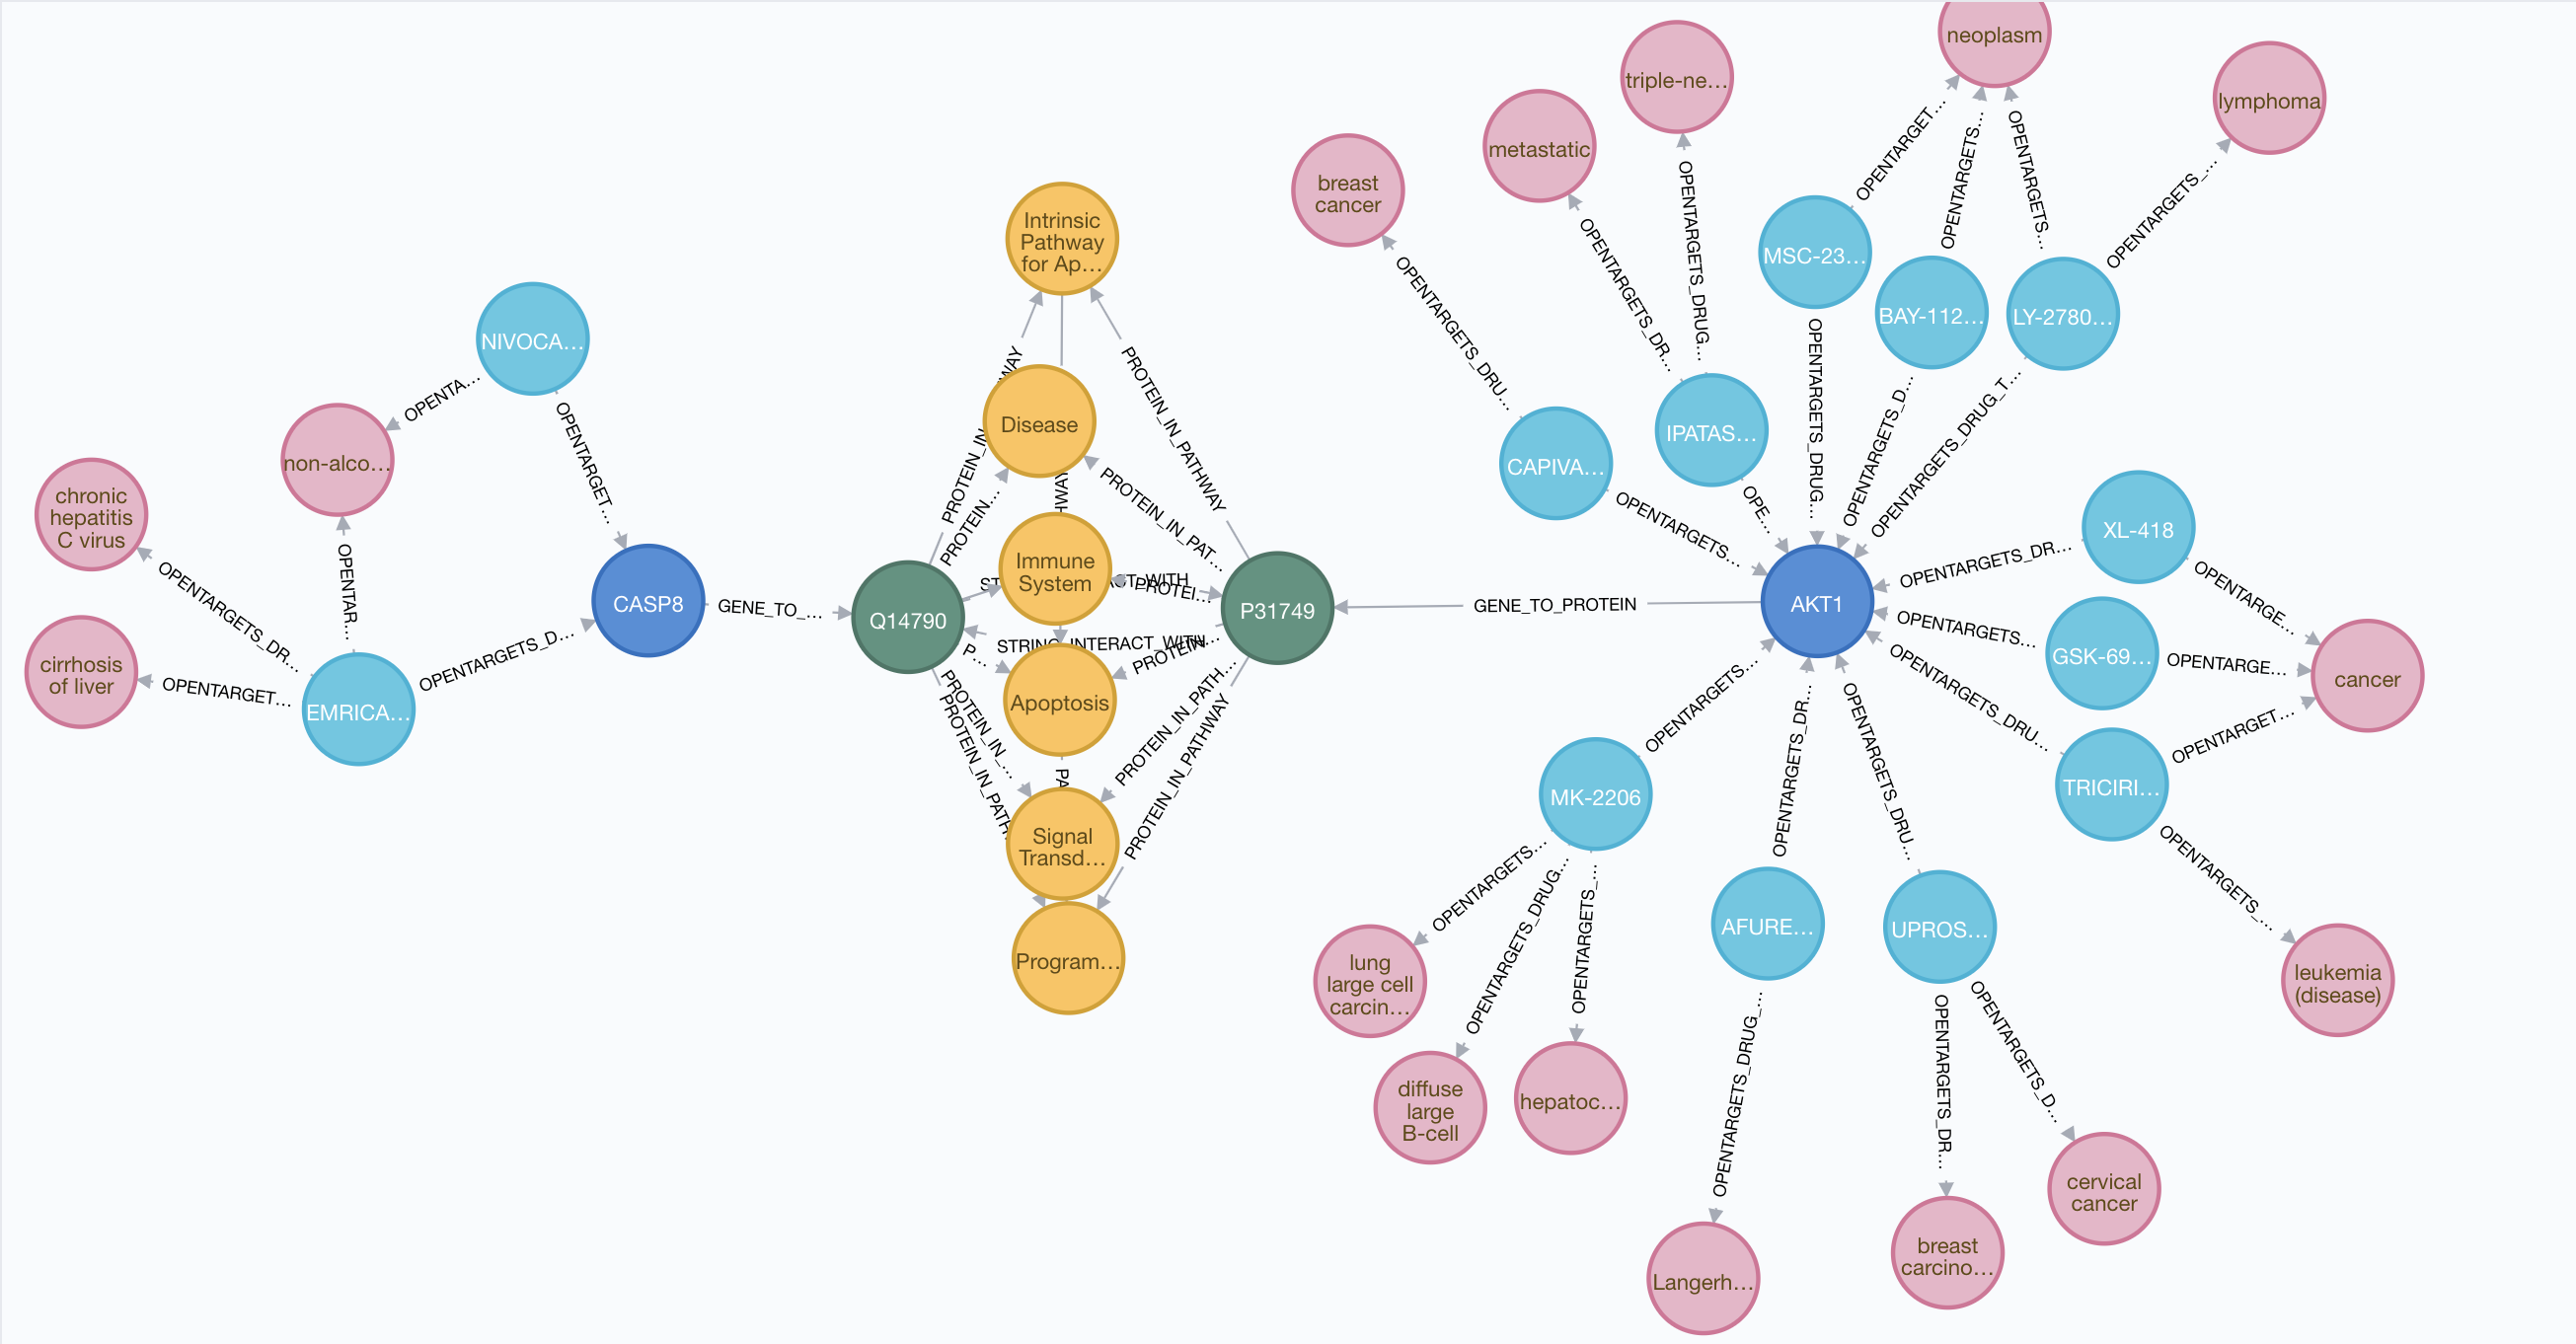

In [30]:
#MATCH (gene1:Gene)-[gene1_to_protein:GENE_TO_PROTEIN]->(protein1:Protein)-[protein1_in_pathway:PROTEIN_IN_PATHWAY]->(pathway:Pathway) <-[protein2_in_pathway:PROTEIN_IN_PATHWAY]-(protein2:Protein)-[gene2_to_protein:GENE_TO_PROTEIN]-(gene2:Gene)
#WHERE gene1.name in ['CASP8'] AND gene2.name in ['AKT1']
#match (gene2)-[gene2_to_drug]-(drug2:Drug)-[drug2_to_disease]-(d2:Disease)
#match (gene1)-[gene1_to_drug]-(drug1:Drug)-[drug1_to_disease]-(d1:Disease)
#set drug1.name = drug1.label
#set d1.name = d1.label
#set drug2.name = drug2.label
#set d2.name = d2.label
#RETURN gene1,protein1,  pathway, protein2, gene2,
#		gene2_to_drug,  drug2, drug2_to_disease, d2,
#        gene1_to_drug,  drug1, drug1_to_disease, d1
Image(filename = "figures/pathway_CASP8-AKT1.png")

In [31]:
x=merged2_bc[merged2_bc['gene1.name'] == 'GATAD2A']
x[x['gene2.name'] == 'HDAC2']

,gene1.name,pathway.name,pathway.id,gene2.name,pathway_type,d.label,is_it_breast_cancer
274244,GATAD2A,ERCC6 (CSB) and EHMT2 (G9a) positively regulat...,R-HSA-427389,HDAC2,other,breast adenocarcinoma,yes
274245,GATAD2A,ERCC6 (CSB) and EHMT2 (G9a) positively regulat...,R-HSA-427389,HDAC2,other,breast cancer,yes
173784,GATAD2A,Infectious disease,R-HSA-5663205,HDAC2,disease_pathway,breast cancer,yes
173783,GATAD2A,Infectious disease,R-HSA-5663205,HDAC2,disease_pathway,breast adenocarcinoma,yes
273693,GATAD2A,Potential therapeutics for SARS,R-HSA-9679191,HDAC2,disease_pathway,breast adenocarcinoma,yes
273694,GATAD2A,Potential therapeutics for SARS,R-HSA-9679191,HDAC2,disease_pathway,breast cancer,yes
278325,GATAD2A,RNA Polymerase I Transcription Initiation,R-HSA-73762,HDAC2,other,breast adenocarcinoma,yes
278326,GATAD2A,RNA Polymerase I Transcription Initiation,R-HSA-73762,HDAC2,other,breast cancer,yes
242047,GATAD2A,PIP3 activates AKT signaling,R-HSA-1257604,HDAC2,other,breast cancer,yes
242046,GATAD2A,PIP3 activates AKT signaling,R-HSA-1257604,HDAC2,other,breast adenocarcinoma,yes


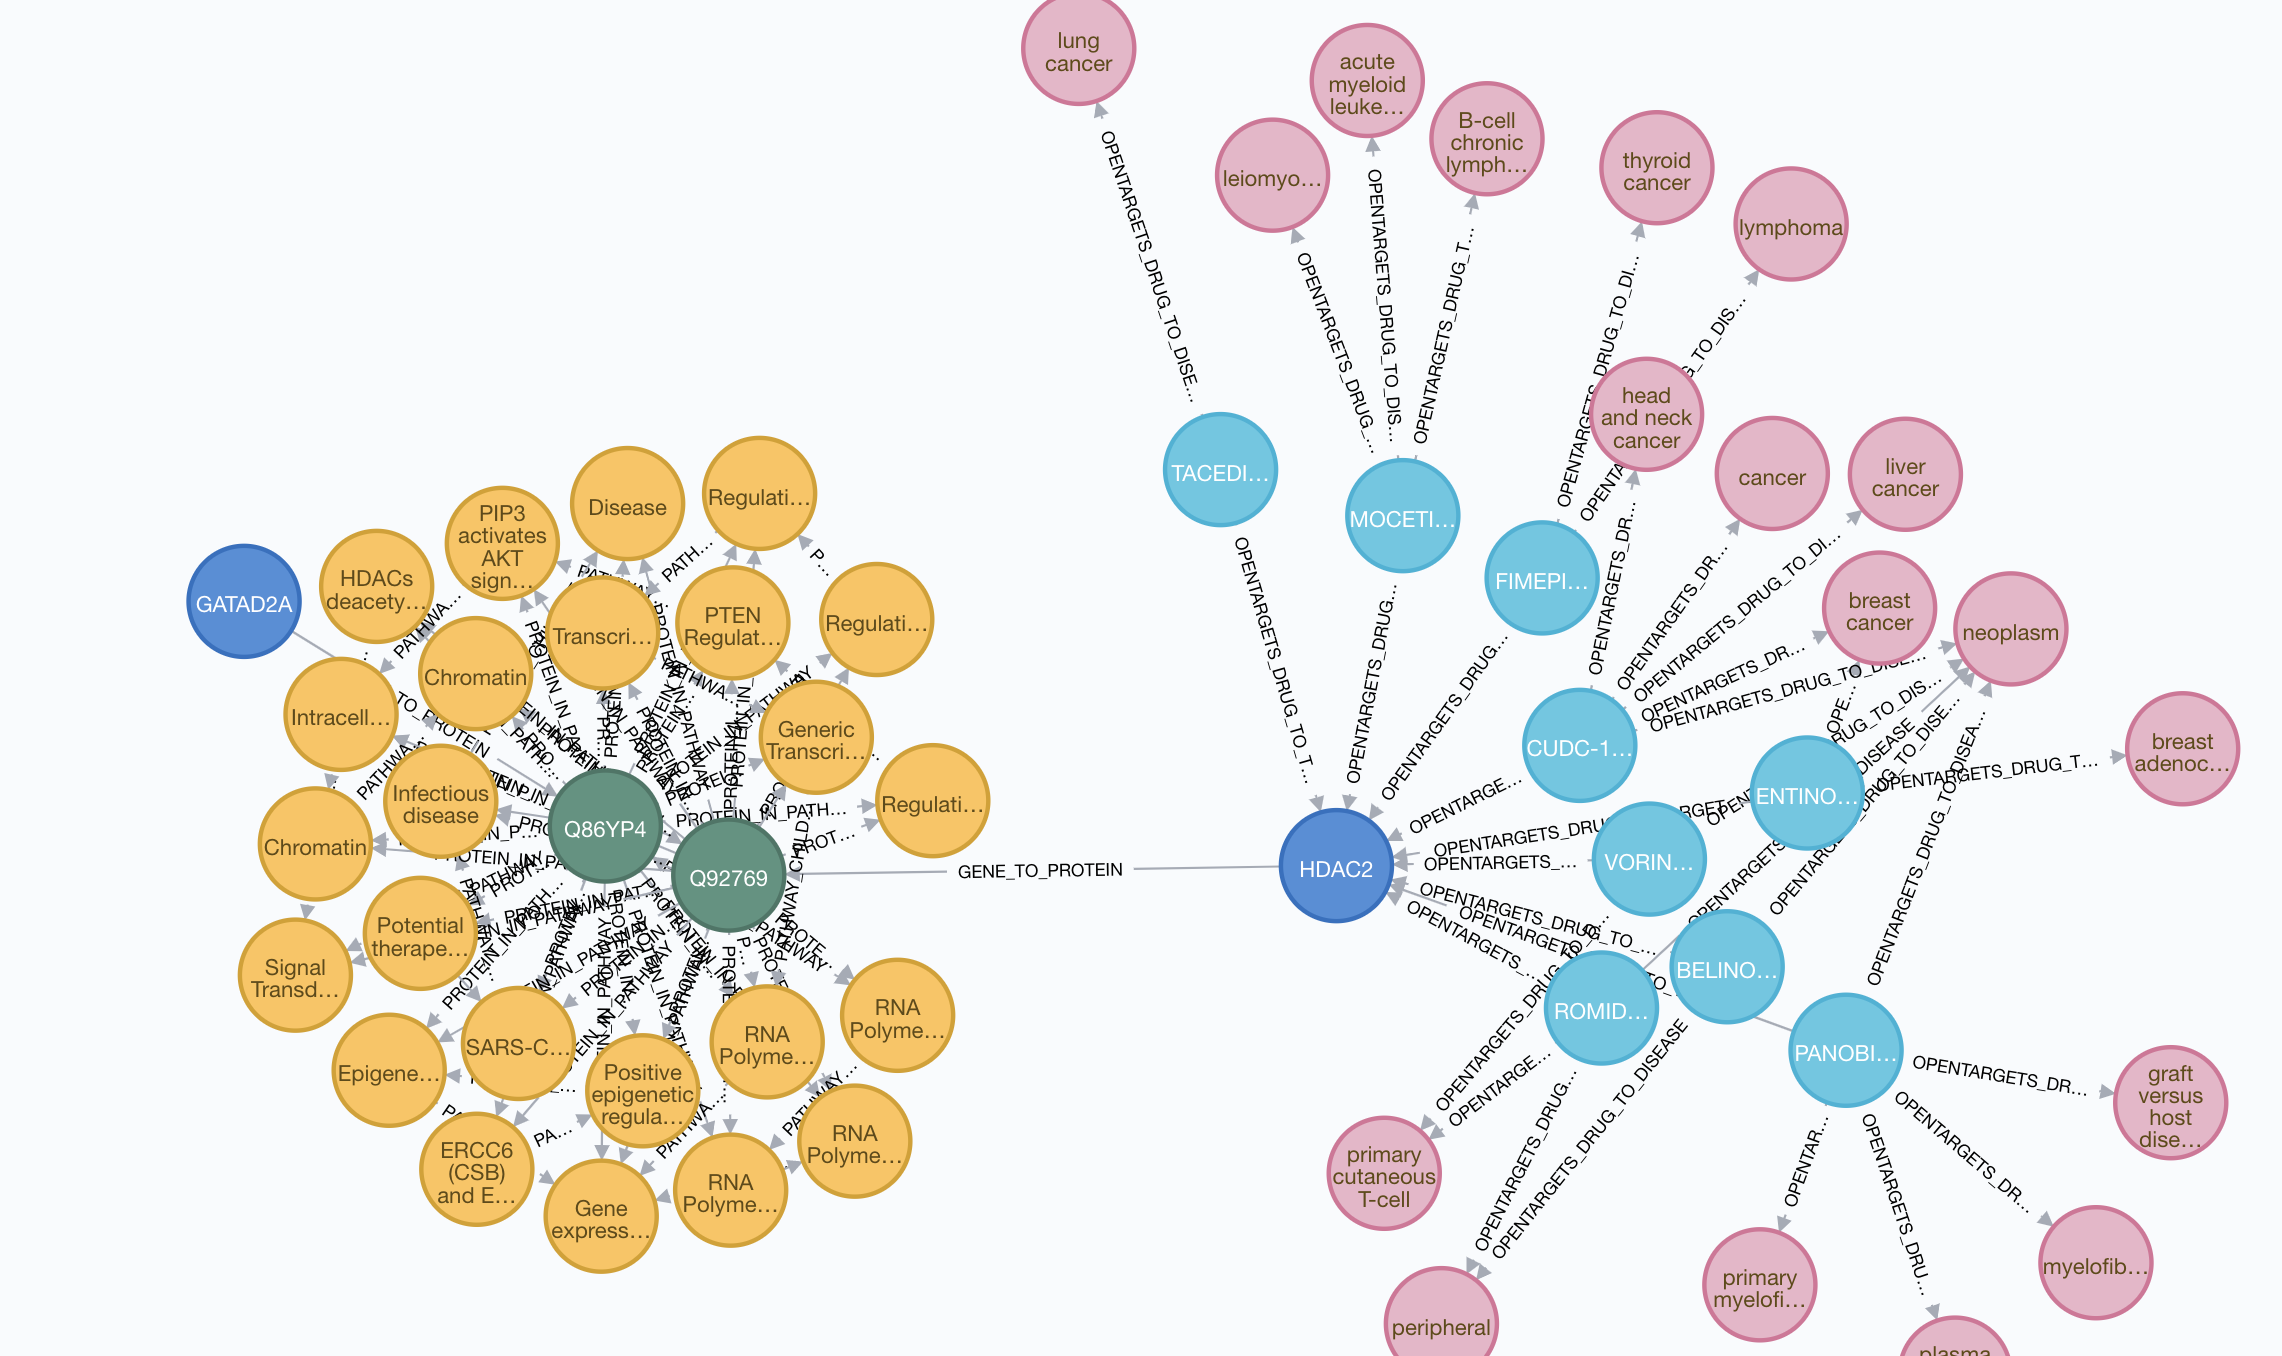

In [32]:
Image(filename = "figures/pathway_GATAD2A_HDAC2.png")


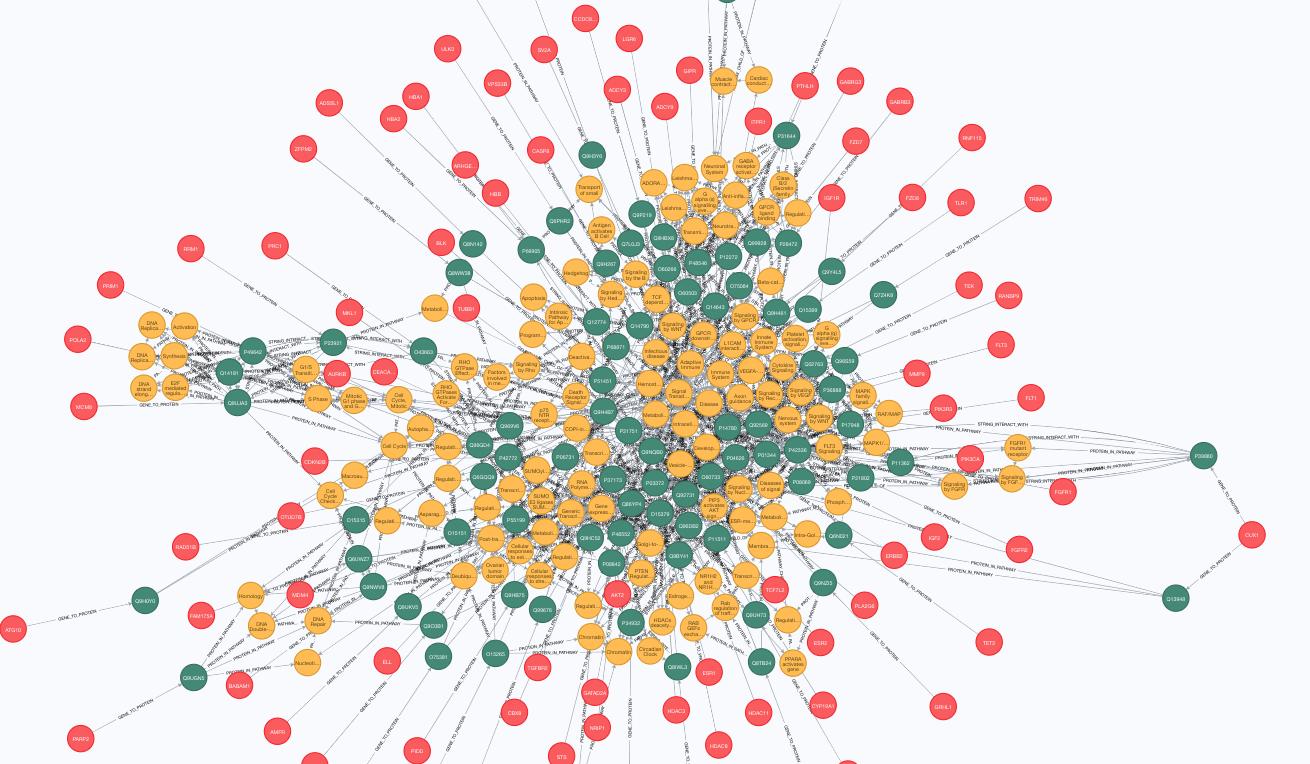

In [33]:
# make a pathway network of all genes (gene1 -> gene2 (BC drug target))
query = """
MATCH (gene1:Gene)-[gene1_to_protein:GENE_TO_PROTEIN]->(protein1:Protein)-[protein1_in_pathway:PROTEIN_IN_PATHWAY]->(pathway:Pathway) <-[protein2_in_pathway:PROTEIN_IN_PATHWAY]-(protein2:Protein)-[gene2_to_protein:GENE_TO_PROTEIN]-(gene2:Gene)
WHERE gene1.name in {gene1_list} AND gene2.name in {gene2_list}
RETURN gene1,protein1,  pathway, protein2, gene2
""".format(gene1_list= genes1[0:5],
           gene2_list = genes2[0:5])

#pathway_df = query_to_df(session, query)
#pathway_df

Image(filename = "figures/pathway_all.png")


To do next:
- filter 10220 genes to be interactiving with the pathway (?)
- check 51 and 138 interact (pairwise)
- check 138 expression in BT
- check druggability of 90
    - look at nearest neighbors if not drugabble
- check protein levels (pQTL)
- check overlap of 51->138 in literature

- recreate pathways using literature